In [1]:
import pandas as pd
import stumpy
import numpy as np
from numba import cuda
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt
import itertools
from numba import cuda

In [2]:
orig_df = pd.read_csv("../../data/interim/train.csv")
df = orig_df.drop(columns=["y", "Participant"])
all_gpu_devices = [device.id for device in cuda.list_devices()]

array([147,  67, 148,  68,  91], dtype=int64)

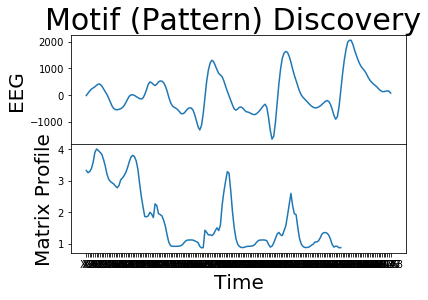

In [3]:
entry = 2614
m= 30
your_time_series= df.loc[entry].astype(float)
mp = stumpy.gpu_stump(your_time_series, m = m, device_id=all_gpu_devices  )

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(your_time_series)
axs[0].set_ylabel('EEG', fontsize='20')
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].plot(mp[:, 0])
mp[:, 0].argsort()[:5]

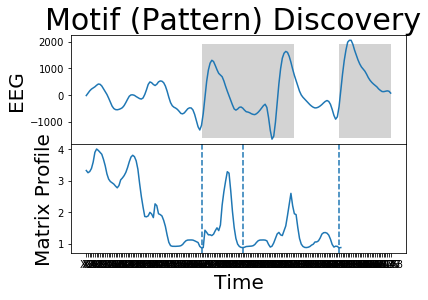

In [4]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')
axs[0].plot(your_time_series)
axs[0].set_ylabel('EEG', fontsize='20')
rect = Rectangle((67, -1600), m, 3500, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((91, -1600), m, 3500, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((147, -1600), m, 3500, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=67, linestyle="dashed")
axs[1].axvline(x=91, linestyle="dashed")
axs[1].axvline(x=147, linestyle="dashed")
axs[1].plot(mp[:, 0])

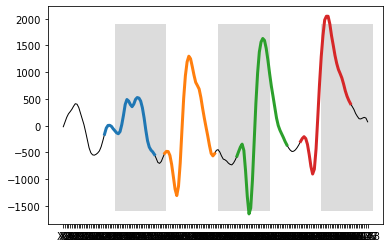

In [5]:
mp = stumpy.stump(your_time_series, m=m)

all_chain_set, unanchored_chain = stumpy.allc(mp[:, 2], mp[:, 3])

plt.plot(your_time_series, linewidth=1, color='black')
for i in range(unanchored_chain.shape[0]):
    y = your_time_series.iloc[unanchored_chain[i]:unanchored_chain[i]+m]
    x = y.index.values
    plt.plot(x, y, linewidth=3)
color = itertools.cycle(['white', 'gainsboro'])
for i, x in enumerate(range(0, your_time_series.shape[0], m)):
    rect = Rectangle((x, -1600), m, 3500, facecolor=next(color))
    plt.gca().add_patch(rect)

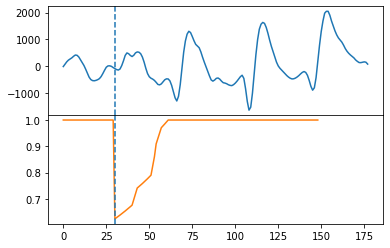

In [6]:
L = 30
cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=2, excl_factor=1)
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(range(your_time_series.shape[0]), your_time_series)
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from functools import partial
from functools import partial

In [4]:
df_float_with_mean_mp = pd.read_csv("../../data/interim/with_mean_mp.csv")

In [9]:
df_float_with_mean_mp.groupby("y")["mean_mp"].mean()

y
0    3.272915
1    2.255896
Name: mean_mp, dtype: float64

In [5]:
def aovQuick(df, dvar, ivar):
    formula = f'{dvar} ~ {ivar}'
    lm = ols(formula, df).fit()
    aov_table = sm.stats.anova_lm(lm, typ=2)
    return aov_table

In [6]:
aovQuick(df_float_with_mean_mp, "mean_mp", "y")

,sum_sq,df,F,PR(>F)
y,1317.691903,1.0,2785.061549,0.0
Residual,3769.414502,7967.0,NaN,NaN


In [10]:
import scipy.stats as stats
import numpy as np
import seaborn as sns

In [11]:
sns.set_context('talk')
sns.set_style("darkgrid")

In [12]:
def interpret_cohens_d(cohens_d):
    """
    Determines text interpretation of effect size given Cohen's d value

    :param cohens_d: float of Cohen's d value
    :returns: effect_size_interpretation: adjective to describe magnitude of effect size
    """
    if 0<=cohens_d<0.1:
        effect_size_interpretation = "Very Small"
    elif 0.1<=cohens_d<0.35:
        effect_size_interpretation = "Small"
    elif 0.35<=cohens_d<0.65:
        effect_size_interpretation = "Medium"
    elif 0.65<=cohens_d<0.9:
        effect_size_interpretation = "Large"
    elif cohens_d >= 0.9:
        effect_size_interpretation = "Very Large"
    return effect_size_interpretation

def two_sample_data_setup_for_cohens_d(mean_1, mean_2, sample_std_dev_1, sample_std_dev_2):
    """
    Creates two normal distributions of data values. 
    Calculates differences in values and standard deviation of list of differences.
    Calculates Cohen's D - equation used in dependent t-tests

    :param mean_1: mean of group one
    :param mean_2: mean of group two
    :param sample_std_dev_1: sample standard deviation of group one
    :param sample_std_dev_2: sample standard deviation of group two

    :returns: values_1, values_2, cohens_d: values for group one, values for group two, Cohen's d
    """
    values_1 = np.random.normal(loc=mean_1, scale=sample_std_dev_1, size=3000)
    values_2 = np.random.normal(loc=mean_2, scale=sample_std_dev_2, size=3000)
    differences_group_values = np.subtract(values_1, values_2)
    std_dev_differences_group_values = np.std(differences_group_values, ddof=1)
    cohens_d = round(abs((mean_1 - mean_2)/std_dev_differences_group_values), 2)
    return values_1, values_2, cohens_d


In [14]:
def visualize_distributions(values_1, values_2, cohens_d, cohens_d_interpretation):
    """
    Plots KDE plots of values from values_1 and values_2.
    Inserts Cohen's d value and interpretation in title

    :param values_1: values in group one
    :param values_2: values in group two 
    :param cohens_d: Cohen's d value
    :param cohens_d_interpretation: text to describe magnitude of effect size
    :returns: plot figure
    """
    plt.figure(figsize=(10, 8))
    sns.distplot(values_1, hist=False, label="Non-Seizure")
    sns.distplot(values_2, hist=False, label="Seizure")
    plt.xlabel("value", labelpad=13)
    plt.ylabel("frequency", labelpad=13)
    plt.title("Distribution of Two Groups with {0} Cohen's d of {1}".format(cohens_d_interpretation, cohens_d), y=1.015, fontsize=22);


In [15]:
mean1 = df_float_with_mean_mp.groupby("y")["mean_mp"].mean()[0]
mean2 = df_float_with_mean_mp.groupby("y")["mean_mp"].mean()[1]

std1 = df_float_with_mean_mp.groupby("y")["mean_mp"].std()[0]
std2 = df_float_with_mean_mp.groupby("y")["mean_mp"].std()[1]

In [16]:
setup_cohen = two_sample_data_setup_for_cohens_d(mean1, mean2, std1, std2)

In [17]:
values_1 = setup_cohen[0]
values_2 = setup_cohen[1]
cohens_d = setup_cohen[2]
cohens_d_interpretation = interpret_cohens_d(cohens_d)

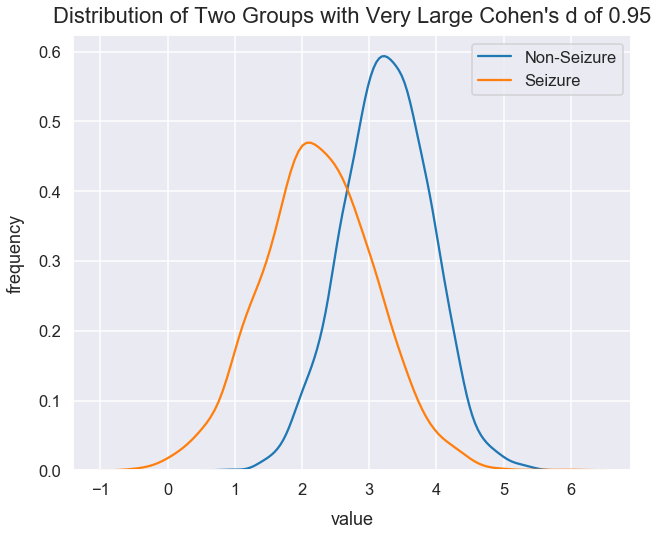

In [18]:
visualize_distributions(values_1, values_2, cohens_d, cohens_d_interpretation)


In [2]:
orig_df = pd.read_csv("../../data/interim/validation.csv")
df = orig_df.drop(columns=["y", "Participant"])
all_gpu_devices = [device.id for device in cuda.list_devices()]

In [5]:
df_float = df.astype(float)

In [17]:
m = 30

mps = df_float.apply(lambda y: 
                     stumpy.gpu_stump(y, 
                                      m = m, 
                                      device_id=all_gpu_devices )[:, 0],
                     axis=1)

mps_df = pd.DataFrame(mps)

reshaped = mps_df.apply(lambda y: 
                     pd.Series(y.values[0]),
                     axis=1)

reshaped["y"] = orig_df["y"]

In [15]:
reshaped.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,y
0,1.941738,1.901662,1.674476,1.296255,1.117657,1.108863,1.114154,1.090459,1.110794,1.190723,...,1.804676,1.656144,1.547189,1.552427,1.580192,1.672563,1.631401,1.640426,1.621895,0
1,2.239853,2.319208,2.270201,2.129049,2.078138,1.986225,1.944429,2.011459,1.968893,2.002581,...,1.214876,1.186330,1.167744,1.172672,1.177595,1.187802,1.147590,1.048800,0.950449,1
2,3.138915,3.698888,4.138673,4.234507,4.215122,4.086208,3.958566,3.903806,4.105363,4.307171,...,3.391907,3.324577,3.493400,3.669972,3.633763,3.533978,3.258921,2.786955,2.234606,0
3,1.842775,2.134232,2.254563,2.316857,2.344961,2.370361,2.398633,2.431664,2.460720,2.484749,...,2.782824,2.585035,2.205194,2.415720,3.054226,3.718165,4.289340,4.316887,4.254295,1
4,3.881884,4.635474,5.256450,4.530496,4.389912,4.328009,3.663652,2.972038,2.737718,2.580242,...,4.872705,5.195812,5.120788,4.969751,4.794657,4.654397,4.125598,3.881884,3.749904,0


In [18]:
descs = reshaped.apply(lambda x: x.describe(), axis=1)

In [14]:
descs.head()

,count,unique,top,freq
0,1,1,"[1.9417377803470448, 1.901661724952824, 1.6744...",1
1,1,1,"[2.239853152607218, 2.3192077517752923, 2.2702...",1
2,1,1,"[3.1389150225386993, 3.6988880726175513, 4.138...",1
3,1,1,"[1.8427745122256982, 2.1342318992855986, 2.254...",1
4,1,1,"[3.8818844779293675, 4.635474495173843, 5.2564...",1


In [19]:
descs_with_y = pd.concat([descs, orig_df["y"]], axis=1)

In [20]:
descs_with_y.loc[lambda x: x["y"]==0, "min"].describe()

count    2731.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: min, dtype: float64

In [21]:
descs_with_y.loc[lambda x: x["y"]==1, "min"].describe()

count    685.000000
mean       0.810942
std        0.254439
min        0.095620
25%        0.649031
50%        1.000000
75%        1.000000
max        1.000000
Name: min, dtype: float64